In [33]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, date

f = open("transaction-data-adhoc-analysis.json", "r")
data = json.load(f)
    
""" 
headers: 'address', 'birthdate', 'mail', 'name', 
    'sex', 'username', 'transaction_items', 'transaction_value', 
    'transaction_date'
"""
df_data = pd.DataFrame(data)

In [34]:
def order_count(orders, column):
    order = [x.split(",") for x in orders.split(";")]
    order = [item for sublist in order for item in sublist]
    order_number = order[order.index(column) + 1]
    order_number = int(order_number[2:len(order_number)-1])
    return order_number

# creating an order tally
order_list = []
for orders in df_data['transaction_items']:
    for order in orders.split(";"):
        category, order_name, order_number = order.split(",")
        if order_name not in order_list:
            order_list.append(order_name)
    
for orders in order_list:
    df_data[orders] = df_data['transaction_items'].apply(lambda row: order_count(row, orders) if orders in row else 0)

df_data.head(5)

,address,birthdate,mail,name,sex,username,transaction_items,transaction_value,transaction_date,Beef Chicharon,Nutrional Milk,Orange Beans,Gummy Vitamins,Yummy Vegetables,Gummy Worms,Kimchi and Seaweed
0,USNS Wagner\nFPO AE 00917,1926/03/11,watsonbrenda@gmail.com,Jennifer Campbell,F,veronicawells,"Exotic Extras,Beef Chicharon,(x4)",5196,2022/01/12,4,0,0,0,0,0,0
1,USCGC Benson\nFPO AP 48794,2016/07/08,moorelisa@gmail.com,Melissa Kim,F,cgilbert,"Exotic Extras,Beef Chicharon,(x3);HealthyKid 3...",12056,2022/01/12,3,4,1,0,0,0,0
2,USCGC Benson\nFPO AP 48794,2016/07/08,moorelisa@gmail.com,Melissa Kim,F,cgilbert,"HealthyKid 3+,Gummy Vitamins,(x3);HealthyKid 3...",5500,2022/01/08,0,0,0,3,2,0,0
3,USCGC Benson\nFPO AP 48794,2016/07/08,moorelisa@gmail.com,Melissa Kim,F,cgilbert,"HealthyKid 3+,Yummy Vegetables,(x1)",500,2022/01/10,0,0,0,0,1,0,0
4,"33911 Hansen Loaf\nWest Sandra, ND 54188",1949/09/27,michael78@yahoo.com,Kristen Cooper,F,qhernandez,"Candy City,Orange Beans,(x3);Candy City,Gummy ...",2697,2022/01/24,0,0,3,1,0,4,0


In [35]:
# getting the month from transaction_date
def find_month(date):
    months = ["", "January", "February", "March", 
              "April", "May", "June", "July", "August",
             "September", "October", "November", "December"]
    
    return months[int(date[5:7])]

df_data['month'] = df_data['transaction_date'].apply(find_month)

In [36]:
# pivot table with months and order count
df_pivotcount_unarranged = pd.pivot_table(data = df_data, index = 'month', values = order_list, aggfunc = 'sum')
df_pivotcount = df_pivotcount_unarranged.reindex(['January', 'February', 'March', 'April', 'May', 'June'])
df_pivotcount = df_pivotcount.reindex(columns = order_list)

df_pivotcount

,Beef Chicharon,Nutrional Milk,Orange Beans,Gummy Vitamins,Yummy Vegetables,Gummy Worms,Kimchi and Seaweed
month,,,,,,,
January,9665,9727,9774,9681,9959,9559,9676
February,10001,9691,10037,9980,10256,9996,9949
March,9816,9876,9611,10145,9896,9986,9967
April,9890,9786,9914,9842,9861,10043,9921
May,10028,9881,9964,9948,9735,9801,9773
June,9902,9767,10106,9980,9722,9934,10104


<AxesSubplot:xlabel='month'>

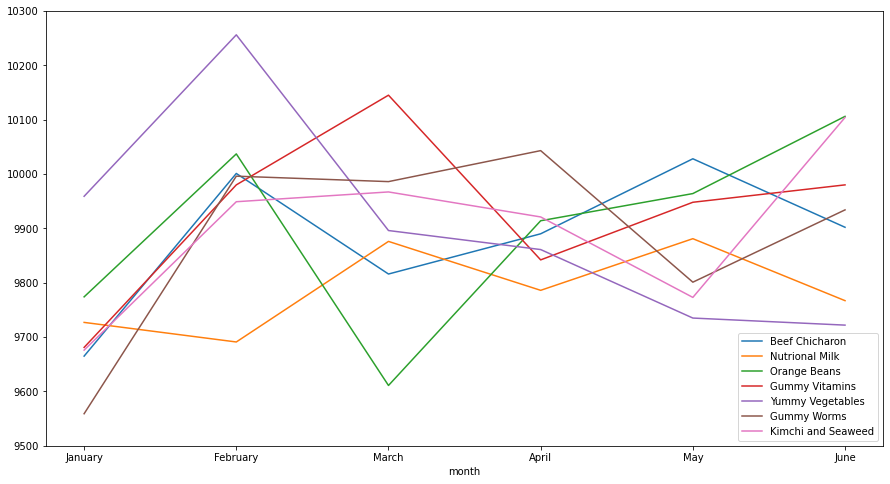

In [37]:
df_pivotcount.plot(kind="line", figsize = (15, 8), ylim = [9500, 10300])

In [46]:
# age bracket of customers
def find_age(birthday):
    birthday = datetime.strptime(birthday, "%Y/%m/%d").date()
    today = date.today()
    return today.year - birthday.year

def find_age_bracket(birthday):
    birthday = datetime.strptime(birthday, "%Y/%m/%d").date()
    year = birthday.year
    
    age_bracket_year = [1927, 1945, 1964, 1980, 1996, 2012, 2025]
    age_bracket_name = ['Greatest', 'Silent', 'Baby Boomer', 'Generation X', 
                        'Millenials', 'Generation Z', 'Generation Alpha']
    
    for x in range(7):
        if year <= age_bracket_year[x]:
            return age_bracket_name[x]

df_data['age'] = df_data['birthdate'].apply(find_age)
df_data['age_bracket']= df_data['birthdate'].apply(find_age_bracket)
df_data[['username', 'birthdate', 'age', 'age_bracket']]

,username,birthdate,age,age_bracket
0,veronicawells,1926/03/11,96,Greatest
1,cgilbert,2016/07/08,6,Generation Alpha
2,cgilbert,2016/07/08,6,Generation Alpha
3,cgilbert,2016/07/08,6,Generation Alpha
4,qhernandez,1949/09/27,73,Baby Boomer
...,...,...,...,...
83031,kmcconnell,2019/10/26,3,Generation Alpha
83032,llowe,1913/11/04,109,Greatest
83033,llowe,1913/11/04,109,Greatest
83034,llowe,1913/11/04,109,Greatest


In [110]:
# age demographic
df_agedemographic = pd.pivot_table(data = df_data, index = 'month', 
                                   columns = 'age_bracket', values = 'transaction_items', aggfunc = len, margins = True)
df_agedemographic = df_agedemographic.reindex(columns = ['Greatest', 'Silent', 'Baby Boomer', 'Generation X', 
                        'Millenials', 'Generation Z', 'Generation Alpha', 'All'], index = ['January', 'February', 'March', 'April', 'May', 'June', 'All'] )
df_agedemographic

age_bracket,Greatest,Silent,Baby Boomer,Generation X,Millenials,Generation Z,Generation Alpha,All
month,,,,,,,,
January,2663,2143,2200,1856,1838,1887,1101,13688
February,2731,2138,2207,1929,1858,1977,1132,13972
March,2724,2231,2159,1844,1803,1968,1173,13902
April,2679,2110,2205,1868,1838,1971,1108,13779
May,2680,2173,2194,1857,1869,1958,1133,13864
June,2698,2127,2177,1906,1856,1923,1144,13831
All,16175,12922,13142,11260,11062,11684,6791,83036


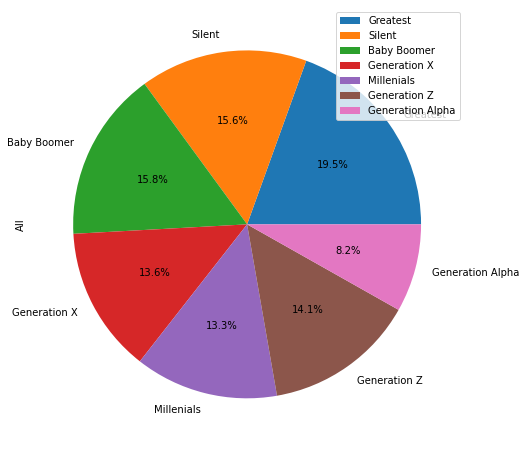

In [112]:
df_agedemographic.loc['All', :'Generation Alpha'].plot(kind="pie", 
                                                      figsize = (15, 8), 
                                                      subplots=True,
                                                      autopct='%1.1f%%')
plt.legend(['Greatest', 'Silent', 'Baby Boomer', 'Generation X', 'Millenials', 'Generation Z', 'Generation Alpha'])

In [120]:
# pivot table
df_item_agebracket = pd.pivot_table(data = df_data, index = ('month', 'age_bracket'), values = order_list, aggfunc = sum, margins = True)
df_item_agebracket = df_item_agebracket.reindex(['Greatest', 'Silent', 'Baby Boomer', 'Generation X', 
                                                  'Millenials', 'Generation Z', 'Generation Alpha'], level = 1)
df_item_agebracket = df_item_agebracket.reindex(['January', 'February', 'March', 'April', 'May', 'June'], level = 0)
df_item_agebracket

Beef Chicharon  Gummy Vitamins  Gummy Worms  \
month    age_bracket                                                     
January  Greatest                    1887            1882         1913   
         Silent                      1602            1510         1506   
         Baby Boomer                 1538            1581         1615   
         Generation X                1332            1305         1309   
         Millenials                  1278            1349         1243   
         Generation Z                1276            1292         1218   
         Generation Alpha             752             762          755   
February Greatest                    2089            1885         1881   
         Silent                      1396            1601         1506   
         Baby Boomer                 1722            1543         1599   
         Generation X                1399            1491         1355   
         Millenials                  1314            1252         1304   
         Generation Z                1320            1399         1465   
         Generation Alpha             761             809          886   
March    Greatest                    1978            1900         1879   
         Silent                      1526            1634         1620   
         Baby Boomer                 1559            1659         1656   
         Generation X                1278            1335         1401   
         Millenials                  1206            1320         1273   
         Generation Z                1451            1378         1383   
         Generation Alpha             818             919          774   
April    Greatest                    1858            1978         1960   
         Silent                      1428            1472         1514   
         Baby Boomer                 1657            1552         1590   
         Generation X                1361            1403         1403   
         Millenials                  1338            1296         1363   
         Generation Z                1434            1402         1414   
         Generation Alpha             814             739          799   
May      Greatest                    1931            1899         1854   
         Silent                      1643            1572         1646   
         Baby Boomer                 1620            1660         1477   
         Generation X                1311            1356         1283   
         Millenials                  1345            1243         1320   
         Generation Z                1381            1447         1445   
         Generation Alpha             797             771          776   
June     Greatest                    1816            1987         2022   
         Silent                      1549            1467         1504   
         Baby Boomer                 1655            1518         1523   
         Generation X                1375            1435         1325   
         Millenials                  1241            1384         1312   
         Generation Z                1423            1353         1389   
         Generation Alpha             843             836          859   

                           Kimchi and Seaweed  Nutrional Milk  Orange Beans  \
month    age_bracket                                                          
January  Greatest                        1862            1909          1917   
         Silent                          1528            1462          1474   
         Baby Boomer                     1546            1661          1577   
         Generation X                    1302            1329          1376   
         Millenials                      1350            1277          1282   
         Generation Z                    1294            1321          1387   
         Generation Alpha                 794             768           761   
February Greatest                        1903            19

In [144]:
def find_state(address):
    states = {'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California', 
              'CO': 'Colorado', 'CT': 'Connecticut','DE': 'Delaware','DC': 'District of Columbia',
              'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois',
              'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 
              'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts', 'MI': 'Michigan', 
              'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska',
              'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 
              'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio',
              'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island',
              'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas',
              'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 
              'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming', 
              'AA': 'Armed Forces the Americas', 'AE': 'Armed Forces Europe', 
              'AP': 'Armed Forces Pacific'}
    
    return states[address.split()[-2]]

df_data['state_address'] = df_data['address'].apply(find_state)
df_itemstate = pd.pivot_table(data = df_data, index = 'state_address', values = order_list, aggfunc = sum)
df_itemstate

,Beef Chicharon,Gummy Vitamins,Gummy Worms,Kimchi and Seaweed,Nutrional Milk,Orange Beans,Yummy Vegetables
state_address,,,,,,,
Alabama,1008,1110,1164,1078,1155,1061,1033
Alaska,962,1074,992,1057,1011,1056,997
Arizona,1156,1043,1096,1055,1157,1121,1029
Arkansas,1011,1058,1012,977,956,919,943
Armed Forces Europe,2023,2139,2020,2110,2178,2208,2110
Armed Forces Pacific,1913,2077,2060,2076,1910,2040,1985
Armed Forces the Americas,2068,2226,2351,2033,1955,2164,2224
California,1005,993,882,892,1025,948,897
Colorado,1124,980,951,1077,996,991,981


In [63]:
# finding the price per item
def item_number(N):
    string = "".join([str(x) for x in list(N)])
    return len(string.replace("0", ""))

df_datavalue = df_data[["username", "month", "transaction_items", "transaction_value"] + order_list].copy()
df_datavalue["item_number"] = df_datavalue.loc[:, 'Beef Chicharon':'Kimchi and Seaweed'].apply(item_number, axis = 1)

price_list = {}
for order in order_list:
    temp = df_datavalue[(df_datavalue["item_number"] == 1) & (df_datavalue[order] != 0)].head(1)
    price_list[order] = [float(temp["transaction_value"] / temp[order])] 
    
df_price_list = pd.DataFrame(price_list).T
df_price_list = df_price_list.rename(columns = {0: 'Price'})
df_price_list

,Price
Beef Chicharon,1299.0
Nutrional Milk,1990.0
Orange Beans,199.0
Gummy Vitamins,1500.0
Yummy Vegetables,500.0
Gummy Worms,150.0
Kimchi and Seaweed,799.0


In [203]:
# finding generated revenue per item per month
df_salerevenue = df_pivotcount.multiply(np.array(df_price_list), axis = 'columns')
df_salerevenue

,Beef Chicharon,Nutrional Milk,Orange Beans,Gummy Vitamins,Yummy Vegetables,Gummy Worms,Kimchi and Seaweed
month,,,,,,,
January,12554835.0,19356730.0,1945026.0,14521500.0,4979500.0,1433850.0,7731124.0
February,12991299.0,19285090.0,1997363.0,14970000.0,5128000.0,1499400.0,7949251.0
March,12750984.0,19653240.0,1912589.0,15217500.0,4948000.0,1497900.0,7963633.0
April,12847110.0,19474140.0,1972886.0,14763000.0,4930500.0,1506450.0,7926879.0
May,13026372.0,19663190.0,1982836.0,14922000.0,4867500.0,1470150.0,7808627.0
June,12862698.0,19436330.0,2011094.0,14970000.0,4861000.0,1490100.0,8073096.0


In [205]:
def convert_string(N):
    return "".join([str(i) for i in list(N)])

def check_status(status):
    if status[-1] == '0':
        return "Inactive"
    status = status.lstrip('0')
    if set(status) == {'1'}:
        return "Engaged"
    else:
        return "Repeater"
    
df_customercount_unarranged = pd.pivot_table(data = df_datavalue, index = 'username', 
                                  columns = 'month', values = 'item_number', 
                                  aggfunc = len, fill_value = 0)
df_customercount = df_customercount_unarranged[['January', 'February', 'March', 'April', 'May', 'June']]

for month in ['January', 'February', 'March', 'April', 'May', 'June']:
    df_customercount[month] = df_customercount[month].apply(lambda x: 0 if x == 0 else 1)

for month in ['January', 'February', 'March', 'April', 'May', 'June']:
    df_customercount["transposed_status"] = df_customercount.loc[:,'January': month].apply(convert_string, axis = 1)
    df_customercount[month + " Status"] = df_customercount["transposed_status"].apply(check_status)

df_customercategory_unarranged = pd.DataFrame()
for month in ['January', 'February', 'March', 'April', 'May', 'June']:
    df = df_customercount[month + " Status"].value_counts()
    if 'Repeater' not in df:
        df['Repeater'] = 0
    df_customercategory_unarranged[month] = df
    
df_customercategory_unarranged.reindex(['Repeater', 'Inactive','Engaged'], fill_value = 1)

,January,February,March,April,May,June
Repeater,0,0,1079,2100,2997,3754
Inactive,1922,1875,1847,1937,1918,1840
Engaged,6583,6630,5579,4468,3590,2911


In [124]:
f.close()

In [138]:
import csv
with open('csvData.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    states = dict()
    for row in reader:
        states[row[2]] = row[0]
        
    states['AA'] = 'Armed Forces the Americas'
    states['AE'] = 'Armed Forces Europe'
    states['AP'] = 'Armed Forces Pacific'

states


{'AL': 'Alabama',
 'AK': 'Alaska',
 'AZ': 'Arizona',
 'AR': 'Arkansas',
 'CA': 'California',
 'CO': 'Colorado',
 'CT': 'Connecticut',
 'DE': 'Delaware',
 'DC': 'District of Columbia',
 'FL': 'Florida',
 'GA': 'Georgia',
 'HI': 'Hawaii',
 'ID': 'Idaho',
 'IL': 'Illinois',
 'IN': 'Indiana',
 'IA': 'Iowa',
 'KS': 'Kansas',
 'KY': 'Kentucky',
 'LA': 'Louisiana',
 'ME': 'Maine',
 'MD': 'Maryland',
 'MA': 'Massachusetts',
 'MI': 'Michigan',
 'MN': 'Minnesota',
 'MS': 'Mississippi',
 'MO': 'Missouri',
 'MT': 'Montana',
 'NE': 'Nebraska',
 'NV': 'Nevada',
 'NH': 'New Hampshire',
 'NJ': 'New Jersey',
 'NM': 'New Mexico',
 'NY': 'New York',
 'NC': 'North Carolina',
 'ND': 'North Dakota',
 'OH': 'Ohio',
 'OK': 'Oklahoma',
 'OR': 'Oregon',
 'PA': 'Pennsylvania',
 'RI': 'Rhode Island',
 'SC': 'South Carolina',
 'SD': 'South Dakota',
 'TN': 'Tennessee',
 'TX': 'Texas',
 'UT': 'Utah',
 'VT': 'Vermont',
 'VA': 'Virginia',
 'WA': 'Washington',
 'WV': 'West Virginia',
 'WI': 'Wisconsin',
 'WY': 'Wyoming